In [1]:
%load_ext autoreload
%autoreload 2

import sys         
sys.path.append('./../../src/') 
from data.ptbxl import create_features_dataset, get_feats_from_all_channels, load_ptbxl_data
from pathlib import Path
from signals.ecg import ECGSignal
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from signals.utils import parse_nested_feats
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed

TARGET = 'diagnostic_class'
DATASET_PATH = Path("./../../data/ptbxl")
SAMPLING_RATE = 100

In [8]:
ptbxl_data = load_ptbxl_data(
    sampling_rate=SAMPLING_RATE,
    path = DATASET_PATH,
    target = TARGET
)

In [2]:
ptbxl_dataset = create_dataset()

train split:   0%|          | 0/12978 [00:00<?, ?it/s]

val split:   0%|          | 0/1642 [00:00<?, ?it/s]

test split:   0%|          | 0/1652 [00:00<?, ?it/s]

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

# model = SVC(probability=True)
model = LGBMClassifier()


X_train = ptbxl_dataset['train']['X']
y_train = ptbxl_dataset['train']['y']

X_val = ptbxl_dataset['val']['X']
y_val = ptbxl_dataset['val']['y']

X_test = ptbxl_dataset['test']['X']
y_test = ptbxl_dataset['test']['y']

model.fit(X_train, y_train)

LGBMClassifier()

In [175]:
save_as_torch_and_npy_files()

In [41]:
from evaluation.metrics import get_classification_metrics
from evaluation.visualisations import plot_feature_importance, plot_confusion_matrix

train_metrics = get_classification_metrics(model.predict_proba(X_train), y_train)
val_metrics = get_classification_metrics(model.predict_proba(X_val), y_val)
test_metrics = get_classification_metrics(model.predict_proba(X_test), y_test)

In [42]:
val_metrics, test_metrics

({'fscore': 0.6247407970724964,
  'acc': 0.7576323987538941,
  'auc': 0.919570282475384},
 {'fscore': 0.6511467628590049,
  'acc': 0.7808814400993171,
  'auc': 0.9213483635956324})

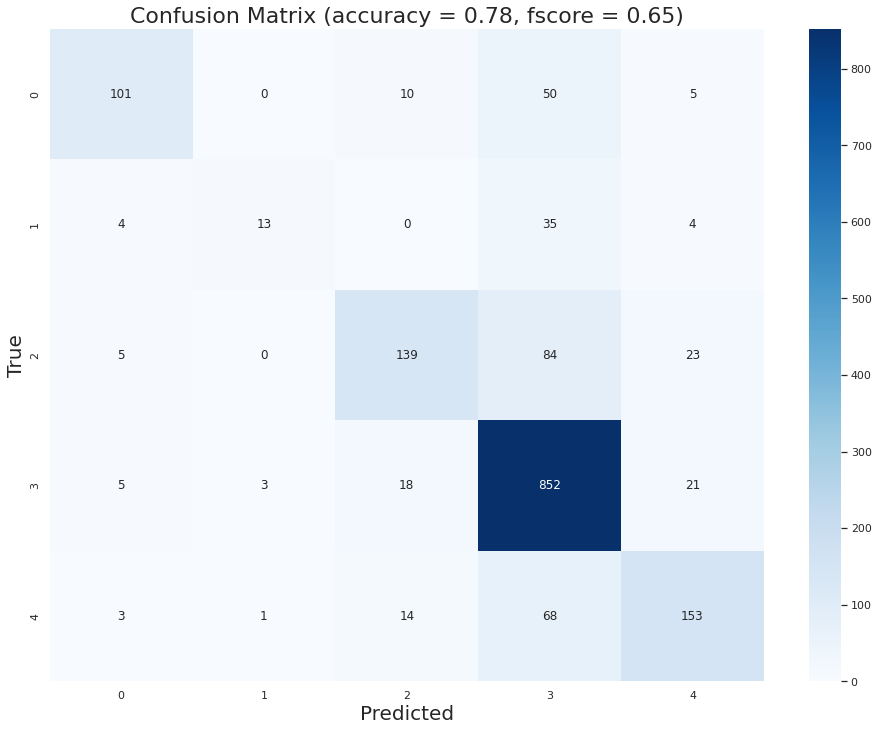

In [43]:
plot_confusion_matrix(y_test, model.predict(X_test), np.unique(y_train))

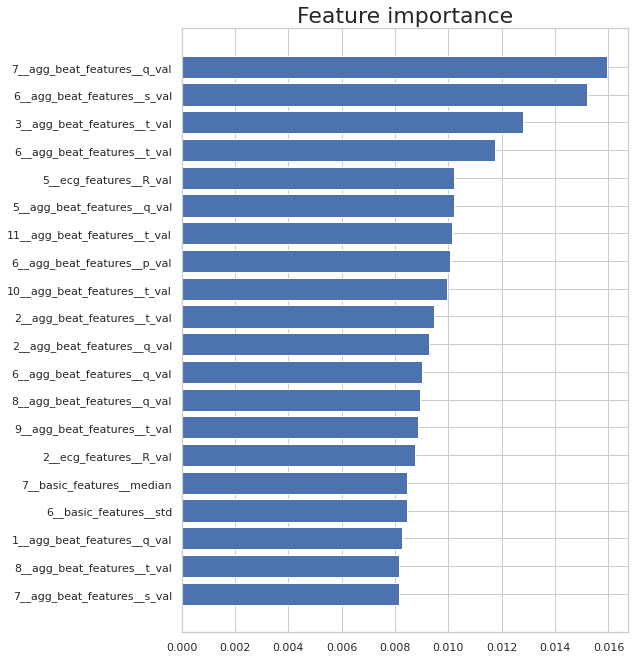

In [44]:
plot_feature_importance(X_train.columns.values, model.feature_importances_, n_best=20)

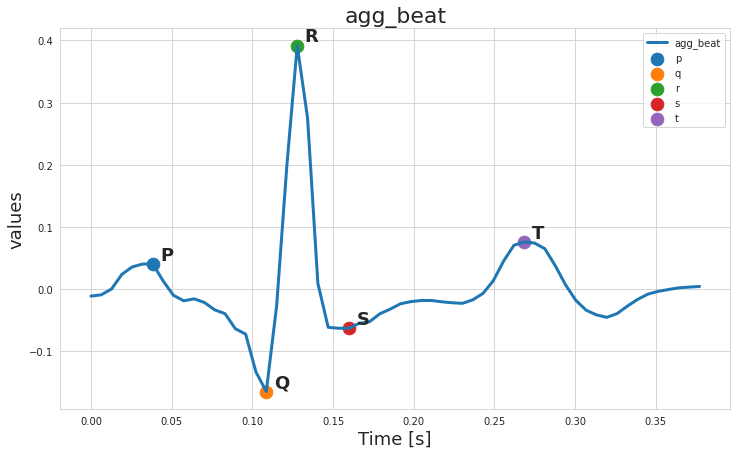

In [9]:
data = ptbxl_data['train']['X'][111, :, 0]
sig = ECGSignal("ecg", data, 100)
# sig.plot()
secg = sig.aggregate()
secg.plot_crit_points()

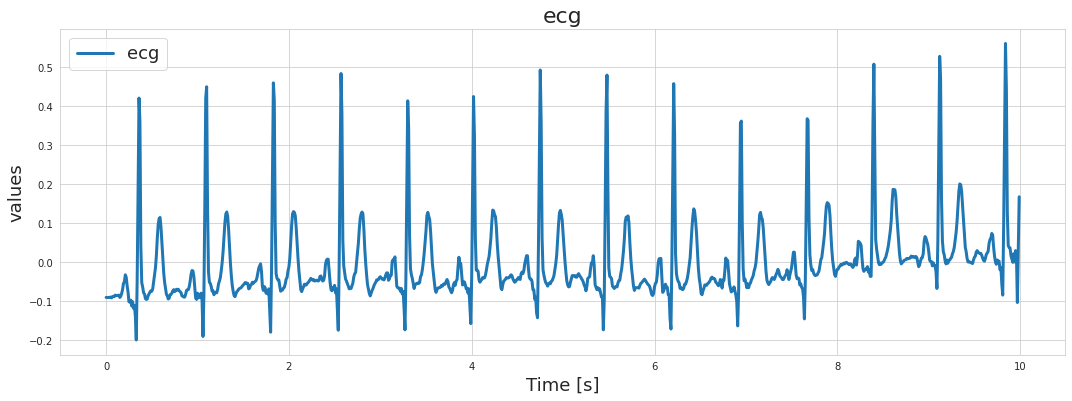

In [10]:
data = ptbxl_data['train']['X'][1111, :, 0]
sig.plot()

In [56]:
from torch import nn
import torch

class MLP(nn.Module):
    def __init__(self, in_size=1000, n_classes=5):
        super().__init__()
        self.model = nn.Sequential(
            # nn.Linear(in_size, in_size // 2),
            # nn.ReLU(),
            # nn.Linear(in_size // 2, in_size // 4),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(in_size, n_classes)
        )
        
    def forward(self, x):
        out = self.model(x)
        probs = F.softmax(out, dim=1)
        if torch.any(probs.isnan()) or torch.any(probs.isinf()):
            print(out)
        return probs
        

In [67]:
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from evaluation.metrics import get_classification_metrics


class PTBXLWaveFormClassifier(LightningModule):
    def __init__(self, in_dims, classifier: nn.Module, learning_rate: float = 1e-3):
        super().__init__()
        self.classifier = classifier
        self.learning_rate = learning_rate
        self.save_hyperparameters('in_dims', 'learning_rate')
    
    def forward(self, x):
        return self.classifier(x)

    def _common_step(self, batch, batch_ids, stage, log=True):
        x, labels = batch
        probs = self(x)
        log_probs = torch.log(probs)
        preds = log_probs.argmax(axis=1)
        if log:
            y_pred_proba = probs.detach().numpy()
            metrics = get_classification_metrics(y_pred_proba, labels, auc=stage in ('val', 'test'))
            for metric, val in metrics.items():
                self.log(f"{stage}/{metric}", val, on_step=False, on_epoch=True)
        return labels, probs, log_probs, preds
        
    def training_step(self, batch, batch_idx):
        labels, probs, log_probs, preds = self._common_step(batch, batch_idx, 'train', log=True)
        loss = F.nll_loss(log_probs, labels)
        return loss
    
    def validation_step(self, batch, batch_idx):
        labels, probs, log_probs, preds = self._common_step(batch, batch_idx, 'val', log=True)
        loss = F.nll_loss(log_probs, labels)
        return log_probs
    
    def predict_step(self, batch, batch_idx):
        _, _, _, preds = self._common_step(batch, batch_idx, 'predict', log=False)
        return preds

    def test_step(self, batch, batch_idx):
        _, _, _, preds = self._common_step(batch, batch_idx, 'test', log=True)
        return preds
    
    def test_epoch_end(self, test_step_outputs):
        pass
        # dummy_input = torch.zeros((1, self.hparams["in_dims"]), device=self.device)
        # model_filename = "model_final.onnx"
        # self.to_onnx(model_filename, dummy_input, export_params=True)
        # wandb.save(model_filename)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-3)

In [68]:
from data.ptbxl import PTBXLWaveformDataModule

ptbxl_datamodule = PTBXLWaveformDataModule(
    sampling_rate=100, target='diagnostic_class', batch_size=64, num_workers=8
)

mlp = MLP()
model = PTBXLWaveFormClassifier(1000, mlp, learning_rate=1e-3)
trainer = Trainer()
trainer.fit(model, ptbxl_datamodule)

/home/shate/.local/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/shate/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name       | Type | Params
------------------------------------
0 | classifier | MLP  | 5.0 K 
------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/shate/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [70]:
trainer.test(model, ptbxl_datamodule)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.5332929782082324     │
│         test/auc          │     0.508471124246488     │
│        test/fscore        │    0.19243253267031443    │
└───────────────────────────┴───────────────────────────┘

[{'test/fscore': 0.19243253267031443,
  'test/acc': 0.5332929782082324,
  'test/auc': 0.508471124246488}]

In [2]:
from data.ptbxl import TENSORS_DATA_PATH
import torch
from biosppy.signals.ecg import ecg

sampling_rate = 100
fs = sampling_rate
split = "train"

data = torch.load(TENSORS_DATA_PATH / f"records{sampling_rate}/{split}_data.pt")

In [4]:
def get_beats_from_signal(sig, fs=100):
    ecg_info = ecg(sig, fs, show=False)
    return ecg_info['templates']

def get_beats_from_all_channels(channels):
    return [get_beats_from_signal(sig) for sig in channels.T]


measurements_beats = Parallel(n_jobs=-1)(delayed(get_beats_from_all_channels)(channels) for channels in tqdm(data[:100]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [42]:
sig = ECGSignal('', -data[666, :, 3], 100)

/home/shate/Desktop/praca_magisterska/medical_signal_representation/notebooks/ecg/./../../src/signals/base.py:203: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f272bf5ecd0> has a label of '_slice(0-9.99)_slice(0-9.99)' which cannot be automatically added to the legend.
  ax.legend(plots, labels, loc=0, fontsize=18)
/home/shate/Desktop/praca_magisterska/medical_signal_representation/notebooks/ecg/./../../src/signals/base.py:203: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f273403d9d0> has a label of '_child0' which cannot be automatically added to the legend.
  ax.legend(plots, labels, loc=0, fontsize=18)
/home/shate/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


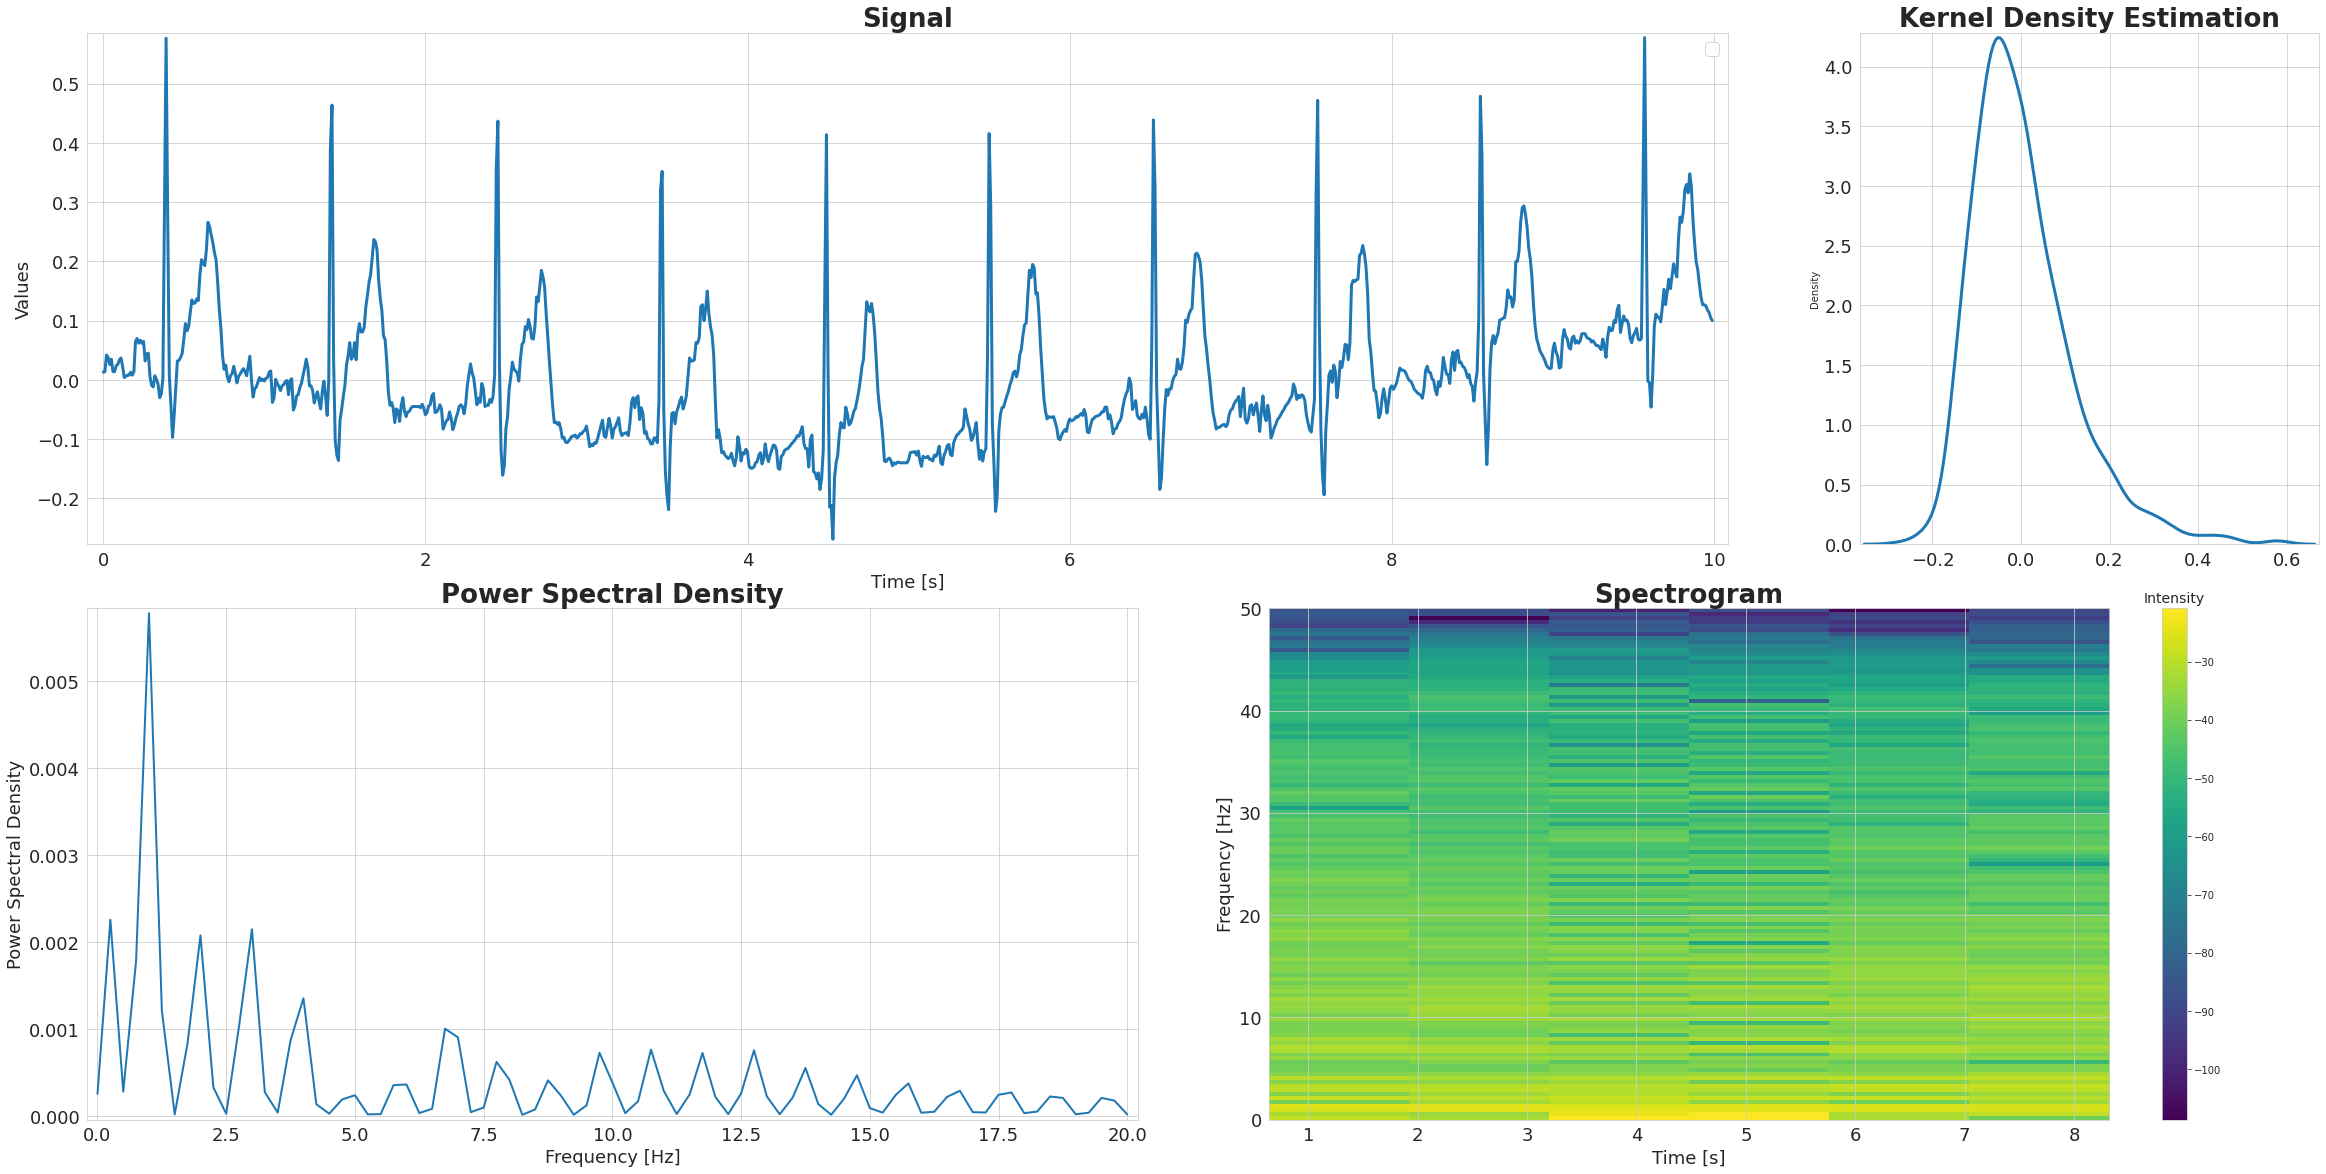

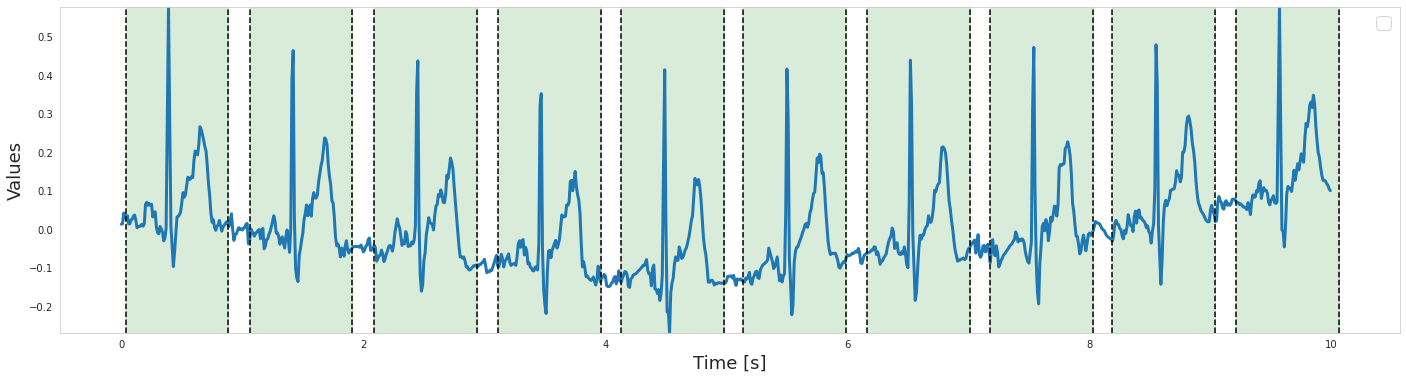

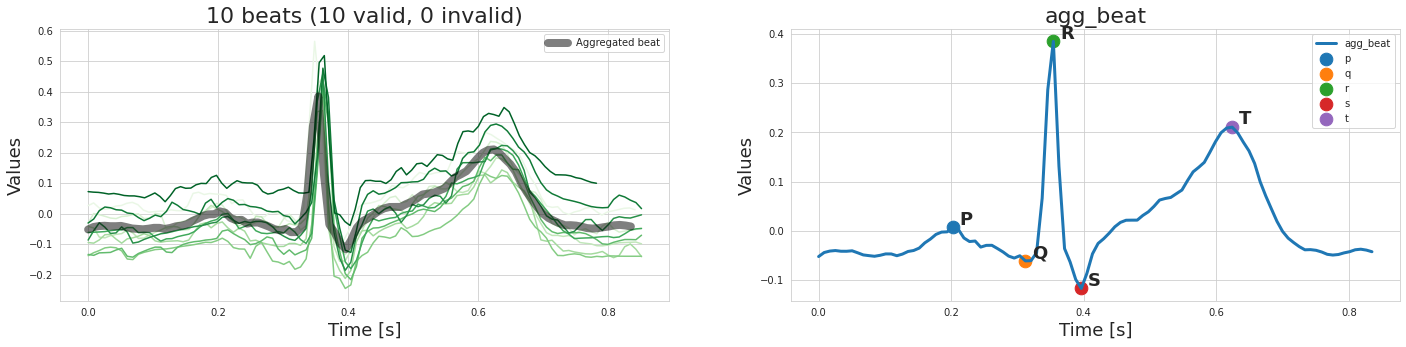

In [43]:
sig.explore()

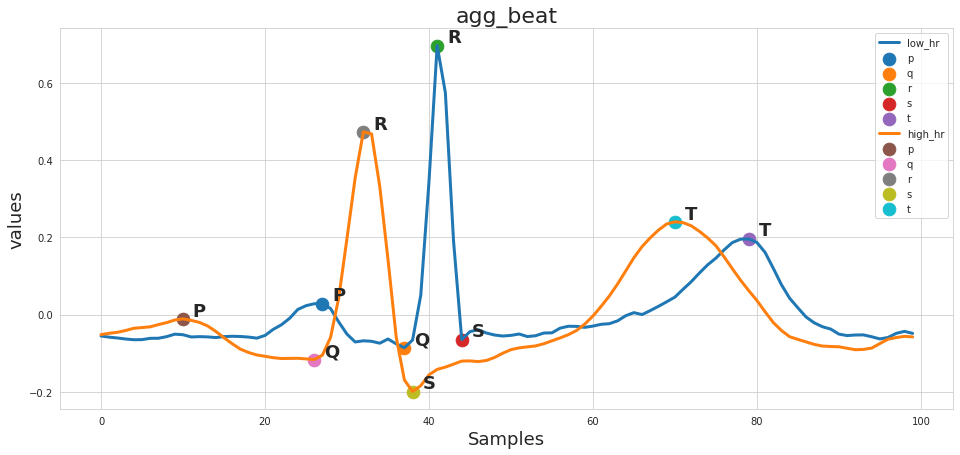

In [6]:
fig, ax = plt.subplots(figsize=(16, 7))
ecg_sig.aggregate().plot(ax=ax, use_samples=True, with_crit_points=True, label='low_hr')
ecg_sig_2.aggregate().plot(ax=ax, use_samples=True, with_crit_points=True, label='high_hr')

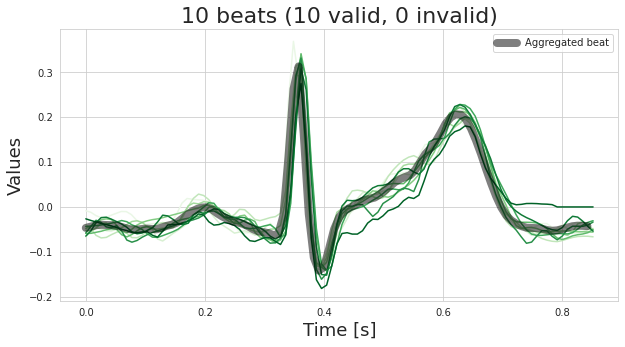

In [53]:
beats = sig.get_beats(plot=True, resample=True, use_raw=False, return_arr=True)

/home/shate/Desktop/praca_magisterska/medical_signal_representation/notebooks/ecg/./../../src/signals/base.py:203: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f272746db80> has a label of '_child0' which cannot be automatically added to the legend.
  ax.legend(plots, labels, loc=0, fontsize=18)


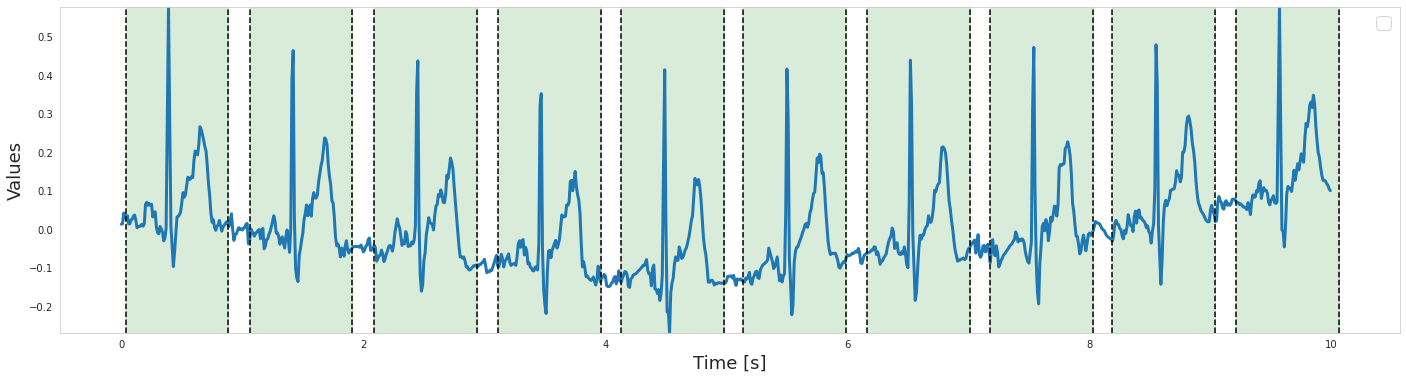

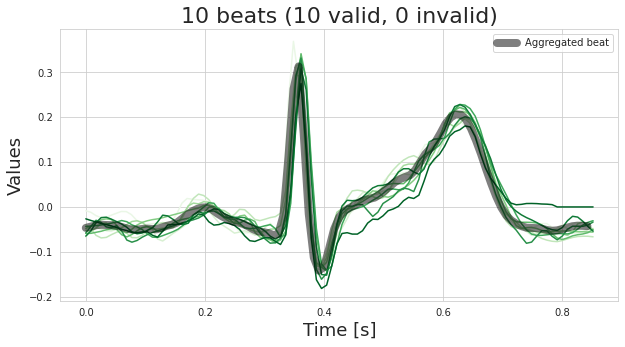

In [54]:
sig.plot_beat_segmentation()
sig.plot_beats(same_ax=True)

In [55]:
t, d = sig.get_beats(return_arr=True)

In [58]:
t.shape, d.shape

((10, 100), (10, 100))

In [62]:
from signals.ecg import create_multichannel_ecg

In [60]:
data[0].shape

torch.Size([1000, 12])

In [ ]:
plt.subplots()

In [96]:
multi_ecg = create_multichannel_ecg(data[5].T, fs)

In [100]:
multi_beats = multi_ecg.get_beats()

In [103]:
[[(beat.start_sec, beat.end_sec) for beat in beats] for name, beats in multi_beats.items()]

[[(0.36, 1.08),
  (1.08, 1.75),
  (1.75, 2.43),
  (2.43, 3.15),
  (3.15, 3.91),
  (3.91, 4.66),
  (4.66, 5.41),
  (5.41, 6.16),
  (6.16, 6.86),
  (6.86, 7.54),
  (7.54, 8.23),
  (8.23, 8.97),
  (8.97, 9.74)],
 [(0.37, 1.09),
  (1.09, 1.75),
  (1.75, 2.44),
  (2.44, 3.15),
  (3.15, 3.91),
  (3.91, 4.66),
  (4.66, 5.41),
  (5.41, 6.17),
  (6.17, 6.87),
  (6.87, 7.54),
  (7.54, 8.24),
  (8.24, 8.98),
  (8.98, 9.75)],
 [(0.4, 1.12),
  (1.12, 1.79),
  (1.79, 2.47),
  (2.47, 3.12),
  (3.12, 3.87),
  (3.87, 4.63),
  (4.63, 5.38),
  (5.4, 6.21),
  (6.21, 6.91),
  (6.91, 7.5),
  (7.5, 8.2),
  (8.2, 9.01),
  (9.01, 9.78)],
 [(0.36, 1.08),
  (1.08, 1.75),
  (1.75, 2.44),
  (2.44, 3.15),
  (3.15, 3.91),
  (3.91, 4.66),
  (4.66, 5.41),
  (5.41, 6.17),
  (6.17, 6.87),
  (6.87, 7.54),
  (7.54, 8.24),
  (8.24, 8.98),
  (8.98, 9.75)],
 [(0.35, 1.07),
  (1.07, 1.74),
  (1.74, 2.42),
  (2.42, 3.14),
  (3.14, 3.9),
  (3.9, 4.65),
  (4.65, 5.4),
  (5.4, 6.16),
  (6.16, 6.85),
  (6.85, 7.53),
  (7.53, 8.22)

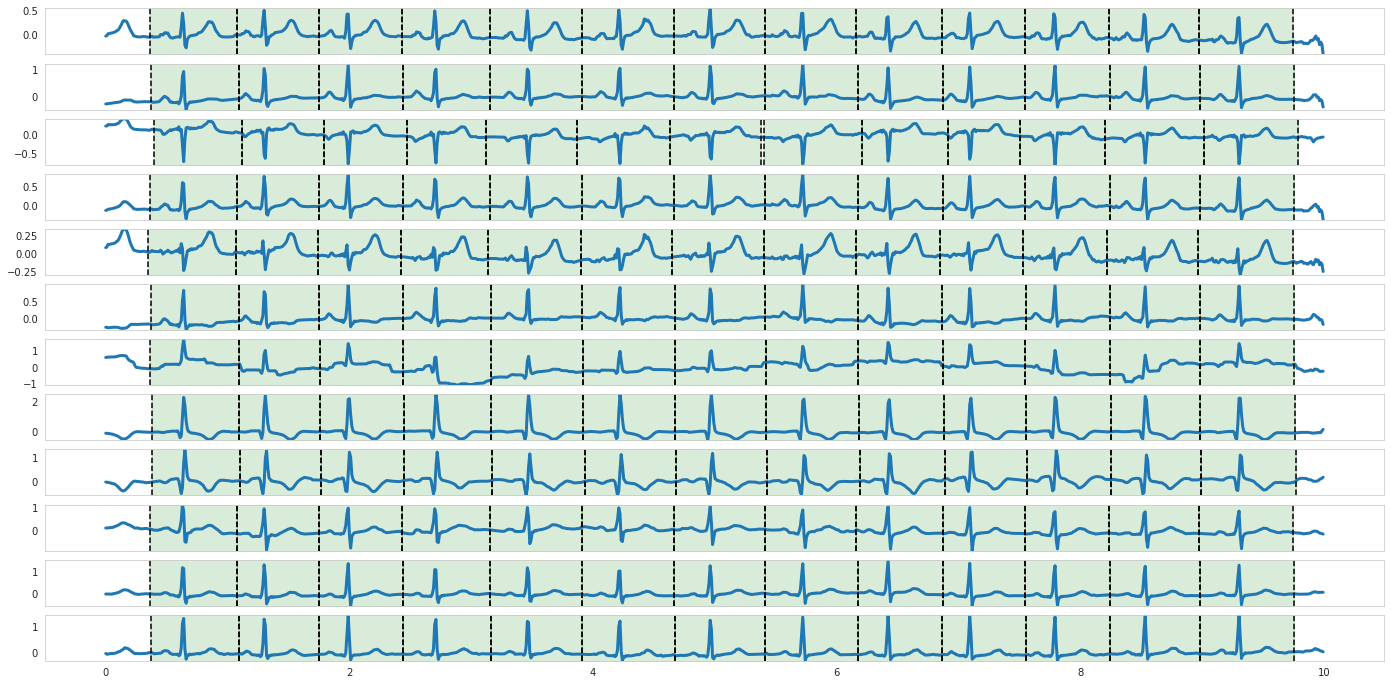

In [97]:
multi_ecg.plot_beats_segmentation()

In [ ]:
class PTBXLPerBeatWaveformDataset(Dataset):
    """PTB-XL Dataset class used in DeepLearning models."""

    def __init__(self, split, sampling_rate=100, target="diagnostic_class", transform=None):
        # TODO: target is still not used -> only diagnostic_class labels are saved as tensors
        # TODO: sampling_rate works only for 100 -> 100 fs samples are saves as tensors

        self.data = torch.load(TENSORS_DATA_PATH / f"records{sampling_rate}/{split}_data.pt")
        self.labels = np.load(TENSORS_DATA_PATH / f"records{sampling_rate}/{split}_labels.npy", allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.data[idx][:, 0].float(), self.labels[idx]


class PTBXLPerBeatWaveformDataModule(LightningDataModule):
    """PTB-XL DataModule class used as DeepLearning models DataLoaders provider."""

    def __init__(self, sampling_rate=100, target="diagnostic_class", batch_size: int = 64, num_workers=8):
        super().__init__()
        self.sampling_rate = sampling_rate
        self.target = target
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train = None
        self.val = None
        self.test = None

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train = PTBXLWaveformDataset(split="train", sampling_rate=self.sampling_rate, target=self.target)
            self.val = PTBXLWaveformDataset(split="val", sampling_rate=self.sampling_rate, target=self.target)
        if stage == "test" or stage is None:
            self.test = PTBXLWaveformDataset(split="test", sampling_rate=self.sampling_rate, target=self.target)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=10 * self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=10 * self.batch_size, num_workers=self.num_workers)
